# Unit Testing Optimisation

## Importing the Packages

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm
import os

import numpy as np
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

import timeit
from tqdm import trange

In [43]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

## Defining SE Covariance

In [44]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [45]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

## Plotting

### Dimensions

In [46]:
def set_size_wide(width_pt=426.79135, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return [fig_width_in, fig_height_in]

In [47]:
def set_size_tall(width_pt=426.79135, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * (1 / golden_ratio) * (subplots[0] / subplots[1])

    return [fig_width_in, fig_height_in]

In [48]:
def set_size_square(width_pt=426.79135, fraction=1):
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in 

    return [fig_width_in, fig_height_in]

### Plots

In [132]:
def plotline(X, Y, Colors = ["tab:blue", "tab:orange"],
            Labels = ["Model Prediction", "Ground Truth"], Name="", Fract=0.35, Line = False):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.4, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )
  if not Line:
    Line = [1.0] * len(X)
  for i in range(len(X)):
    Ax.plot(X[i], Y[i], color = Colors[i], label = Labels[i], linewidth = Line[i])

  Ax.set_xlabel(r"{Number of Filter Time Bins, $D$}")
  Ax.set_ylabel(r"{Runtime $(s)$}")

  Ax.autoscale(enable=True, axis='x', tight=True)
  Ax.legend()
  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  print(Filepath + "/" + Name + '.pgf')
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)

In [50]:
def plotfilt(X, Y, ScattX, ScattY, FillX, ErrorBars, Colors = ["tab:blue", "tab:orange"],
            Labels = ["Model Prediction", "Ground Truth"], ScattL="", Name="", Fract=0.35, Legend=False):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.4, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  Legfig = plt.figure()
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )
  Lines = [0] * len(X)
  for i in range(len(X)):
    Lines[i] = Ax.plot(X[i], Y[i], color = Colors[i], label = Labels[i])

  Ax.fill_between(FillX, *ErrorBars, alpha = 0.3, zorder=1)
  Ax.scatter(ScattX, ScattY, s = 50, label = ScattL, marker = '+', c='r', alpha = 0.8, zorder = 5)
  
  Ax.set_xlabel(r"{Time ($s$)}")
  Ax.set_ylabel(r"{Speed $\left(\frac{m}{s}\right)$}")

  Ax.set_xlim([0.0, 1.0])

  Lns, Lbl = Ax.get_legend_handles_labels()
  Legfig.legend(Lns, Lbl, loc='center', ncol = 4, columnspacing = 0.7)

  Ax.lines.pop(-1)
  plt.draw()
  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)
  if Legend:
    Legfig.savefig(Filepath + "/" + Name + 'Legend' + '.pgf', format = 'pgf', bbox_inches = 'tight')

In [51]:
def plotout(X, Y, FillX, ErrorBars, Colors = ["tab:blue", "tab:orange"],
            Labels = ["Model Prediction", "Ground Truth"], Name="", Fract=0.35):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.4, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  Legfig = plt.figure()
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )

  for i in range(len(X)):
    Ax.plot(X[i], Y[i], color = Colors[i], label = Labels[i], linewidth=0.4 * (2 * i + 1), zorder = i)

  Ax.fill_between(FillX, *ErrorBars, alpha = 0.3, zorder=1)
  
  Ax.set_xlabel(r"{Time ($s$)}")
  Ax.set_ylabel(r"{Speed $\left(\frac{m}{s}\right)$}")

  Ax.autoscale(enable=True, axis='x', tight=True)

  Lns, Lbl = Ax.get_legend_handles_labels()
  Legfig.legend(Lns, Lbl, loc='center', ncol = 2)

  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  print(Filepath + "/" + Name + '.pgf')
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)

## Creating Test Data

In [52]:
key = random.PRNGKey(6)
key, *subkeys = random.split(key, 4)

In [53]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [54]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 10.0

# Maximum index of input data
k = np.floor(x_maxt/time_bin).astype(np.int64)

xtime = np.linspace(0.0, x_maxt, k + 1)

xtest = random.bernoulli(subkeyx, 0.01, (k+1,)).astype(np.float64)

### True Filter

In [55]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 1.00

# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, n + 1)

# Damped frequency
w_d = 18.0

# Sqrt True rise rate
tau_rise = np.sqrt(0.09)

# Sqrt True diff
tau_diff = np.sqrt(0.001)

# True lag
lag = 0.05

env_true = AlpEnvelope(ftime, tau_rise, tau_diff, lag)

# Envelope peak
sqtr = tau_rise ** 2
sqtd = sqtr + tau_diff ** 2
tmax = (np.log(sqtr / sqtd) * sqtd * sqtr) / (sqtr - sqtd)

ftrue = np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))) * env_true

### True Noise

In [56]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.5

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (k + 1,))

### Output

In [57]:
# Padding and applying the FFT
xpad = np.append(xtest, np.zeros(n))
fpad = np.append(ftrue, np.zeros(k))

x_fft = np.fft.rfft(xpad)
f_fft = np.fft.rfft(fpad)

fftmul = x_fft * f_fft

ynonoise = np.fft.irfft(fftmul, n + k + 1)[:k + 1]

ytest = ynonoise + noise_vec
ytime = np.linspace(0.0, x_maxt, k + 1)

## Variational Inference

### ELBO

#### Kl Divergence Term

In [58]:
@jit
def KL_Term(L_Matrix, V_Vector, M):
  return 0.5 * (- jnp.sum(jnp.log(jnp.diag(L_Matrix) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - M)

#### Log-Likelihood

In [59]:
@partial(jit, static_argnums = (2, 3, ))
def Log_Likelihood(F_Pad, Sigma_n, N, K, Y_Test, X_Fft):

  F_Fft = jnp.fft.rfft(F_Pad)

  Mean = jnp.fft.irfft(X_Fft * F_Fft, N + K + 1)[: K + 1]
  
  return - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                  jnp.sum((Y_Test - Mean)**2)/(Sigma_n ** 2))

In [60]:
Vec_LL = jit(vmap(Log_Likelihood, in_axes = [1, None, None, None, None, None]),
             static_argnums = (2,3,))

#### Expected Log-Likelihood

In [61]:
@partial(jit, static_argnums = range(9,13))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey):

  K_MM = Squared_exp(Z_Vector, Z_Vector.T, Sigma_f, Ell)
  K_MN = Squared_exp(Z_Vector, F_Time, Sigma_f, Ell)
  C = jnp.linalg.cholesky(K_MM + 1e-6 * jnp.eye(M)) 
  K_NN = Squared_exp(F_Time, F_TimeT, Sigma_f, Ell)
  
  B = jsc.linalg.solve_triangular(C, K_MN, lower = True)

  BT = B.T

  Mu_q = B.T @ V_Vector

  V_q = K_NN + BT @ (L_Matrix @ L_Matrix.T - jnp.eye(M)) @ B

  Chol_Vq = jnp.linalg.cholesky(V_q + 1e-6 * jnp.eye(N + 1))

  F_Samples = (Mu_q + Chol_Vq @ random.normal(Subkey, (N + 1, Number_F))) * AlpEnvelope(F_TimeT, TRise, TauDiff, Lag)

  F_Samples = jnp.vstack((F_Samples, jnp.zeros((K, Number_F))))

  Likelihoods = Vec_LL(F_Samples, Sigma_n, N, K, Y_Test, X_Fft)

  return jnp.mean(Likelihoods)

#### ELBO

In [62]:
@partial(jit, static_argnums = range(10, 14))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise, TauDiff, Lag, Number_F,
         M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey):
         
  Lag = Lag ** 2.0
  
  Z_Vector = (0.5 * jnp.sin( jnp.pi * (Z_Fractions - 0.5)) + 0.5) * (F_Time[-1] - Lag) + Lag

  D = jnp.diag(jnp.exp(L_Diag))

  L_Matrix = (D + jnp.zeros((M, M))).at[jnp.tril_indices(M, -1)].set(L_ODiag)

  KL = KL_Term(L_Matrix, V_Vector, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  
  return (KL-Exp)/(K + 1)

In [63]:
Grad_Bound = jit(value_and_grad(Neg_ELBO, argnums = range(10)), static_argnums = range(10, 14))

### Optimiser

#### Sub-function Definitions

In [64]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [65]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [66]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [67]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [68]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [69]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [70]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [71]:
@jit
def CAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(CFinState, X, Mhat, Vhat)

  return X, M, V

In [72]:
@jit
def MAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(MFinState, X, Mhat, Vhat)

  return X, M, V

In [73]:
@jit
def FAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(FFinState, X, Mhat, Vhat)

  return X, M, V

In [74]:
@partial(jit, static_argnums = range(12,16))
def _CUpdate(Iter, X, Subkey, Key, ELBO_History, Step, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT,
             Num_Coarse_Fs, M, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = CAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkey, Key, ELBO_History, Step, Mad, Vad)

In [75]:
@partial(jit, static_argnums = range(12,16))
def _MUpdate(Iter, X, Subkey, Key, ELBO_History, Step, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT,
             Num_Coarse_Fs, M, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = MAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkey, Key, ELBO_History, Step, Mad, Vad)

In [76]:
@partial(jit, static_argnums = range(12,16))
def _FUpdate(Iter, X, Subkey, Key, ELBO_History, Step, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT,
             Num_Coarse_Fs, M, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = FAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkey, Key, ELBO_History, Step, Mad, Vad)

#### Adam Function Definition

In [84]:
@partial(jit, static_argnums = range(5, 9))
def AdamOpt(Init_Params, X_Fft, Y_Test, F_Time, F_TimeT, M, N, K, Num_Fs,              
                        Coarse_Schedule = jnp.asarray([400, 400, 700]), Mid_Schedule = jnp.asarray([16500]),
                        Fine_Iters = 2000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = jnp.zeros(20000)
  Step = 0
  Mad = tree_map(jnp.zeros_like, Init_Params)
  Vad = tree_map(jnp.zeros_like, Init_Params)
  Key = random.PRNGKey(20)
  Key, Subkey = random.split(Key)
  Params = Init_Params

  def CUpdate(Iter, State):
    return _CUpdate(Iter, *State, Y_Test, X_Fft, F_Time, F_TimeT, Num_Fs, M, N, K)

  def MUpdate(Iter, State):
    return _MUpdate(Iter, *State, Y_Test, X_Fft, F_Time, F_TimeT, Num_Fs, M, N, K)

  def FUpdate(Iter, State):
    return _FUpdate(Iter, *State, Y_Test, X_Fft, F_Time, F_TimeT, Num_Fs, M, N, K)

  JCUpdate = jit(CUpdate)
  JMUpdate = jit(MUpdate)
  JFUpdate = jit(FUpdate)

  def CReset(Iter, State):
    InOptState = lax.fori_loop(0, Coarse_Schedule[Iter], JCUpdate, State)
    return InOptState

  def MReset(Iter, State):
    InOptState = lax.fori_loop(0, Mid_Schedule[Iter], JMUpdate, State)
    return InOptState

  JCReset = jit(CReset)
  JMReset = jit(MReset)

  OptState = lax.fori_loop(0, len(Coarse_Schedule), JCReset, (Params, Subkey, Key, ELBO_History, Step, Mad, Vad))

  OptState = lax.fori_loop(0, len(Mid_Schedule), JMReset, OptState)

  OptState = lax.fori_loop(0, Fine_Iters, JFUpdate, OptState)

  return OptState[0][0]

In [85]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 5.0
iell = 0.002
isigma_n = 0.000000005


itrise = np.sqrt(0.05)
itaudiff = np.sqrt(0.1)
ilag = np.sqrt(0.01)

# Variational parameters
num_ind = 5
# iz_fracs = [0.0]
# for i in range(num_ind - 1):
#   iz_fracs.append(np.sqrt(iz_fracs[i]**2 + 1/num_ind))
# iz_fracs = jnp.asarray(iz_fracs).reshape((num_ind, 1))
iz_final = jnp.linspace(0.0, 1.0, num_ind).reshape((num_ind, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
# iz_vector = jnp.linspace(ftime[0], ftime[-1], num_ind).reshape((num_ind, 1))
key, *subkeys = random.split(key, 4)
iv_vector = (jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-3], (num_ind,))).reshape((num_ind, 1))
il_diag = jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-2], (num_ind,))
il_odiag = jnp.zeros(int((num_ind ** 2 - num_ind) / 2)) + \
            0.1 * random.normal(subkeys[-1], (int((num_ind ** 2 - num_ind) / 2),))
num_f = 10
ftimet = ftime.reshape((n + 1, 1))

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, opt_subkey = random.split(opt_key)

params = (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag)
consparams = (num_ind, n, k, ytest, x_fft, ftime, ftimet)

In [86]:
numpoints = 100
flengths = np.linspace(10, 1000, numpoints).astype(np.int32)
timesarray = np.zeros(numpoints)

In [87]:
# Time horizon for input data
x_maxt = 5.1

# Maximum index of input data
k = np.floor(x_maxt/time_bin).astype(np.int64)

xtime = np.linspace(0.0, x_maxt, k + 1)

xtest = random.bernoulli(subkeyx, 0.01, (k+1,)).astype(np.float64)

### True Filter
subkeyf = subkeys[-2]

# Damped frequency
w_d = 18.0

# Sqrt True rise rate
tau_rise = np.sqrt(0.09)

# Sqrt True diff
tau_diff = np.sqrt(0.001)

# True lag
lag = 0.05

### True Noise
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.5

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (k + 1,))

# Envelope peak
sqtr = tau_rise ** 2
sqtd = sqtr + tau_diff ** 2
tmax = (np.log(sqtr / sqtd) * sqtd * sqtr) / (sqtr - sqtd)

ytime = np.linspace(0.0, x_maxt, k + 1)

In [88]:
jnp.ones(10).block_until_ready()

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float64)

In [ ]:
for i in trange(100):
  n = flengths[i]
  
  # Filter horizon
  f_maxt = n * time_bin

  ftime = np.linspace(0.0, f_maxt, n + 1)
  ftimet = ftime.reshape(n + 1, 1)

  env_true = AlpEnvelope(ftime, tau_rise, tau_diff, lag)

  ftrue = np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))) * env_true

  ### Output
  # Padding and applying the FFT
  xpad = np.append(xtest, np.zeros(n))
  fpad = np.append(ftrue, np.zeros(k))

  x_fft = np.fft.rfft(xpad)
  f_fft = np.fft.rfft(fpad)

  fftmul = x_fft * f_fft

  ynonoise = np.fft.irfft(fftmul, n + k + 1)[:k + 1]

  ytest = ynonoise + noise_vec

  timecom = timeit.timeit('a = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f).block_until_ready()',number=5, globals = globals())
  print(timecom)
  timesarray[i] = timecom 

In [122]:
x = flengths[:72]
y = timesarray[:72] / 5

In [123]:
pols = np.polyfit(x, y, 3)

In [124]:
print(pols)

[2.13577084e-07 2.45939372e-04 8.95178279e-02 2.39852444e+01]


In [125]:
polyac = np.poly1d(pols)

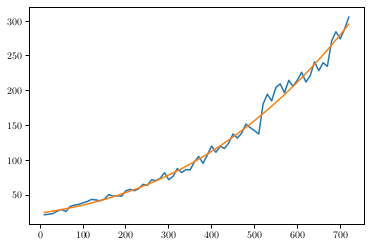

In [126]:
plt.plot(flengths[:72], y)
plt.plot(flengths[:72], polyac(flengths[:72]))

/home/sgome/Project/Reports/Final-Report/Figures/Runtime.pgf


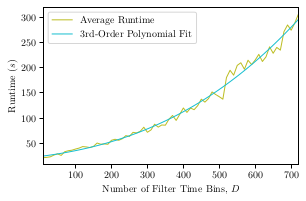

: 

In [133]:
plotline([x] * 2, [y, polyac(x)], Colors=["tab:olive", "tab:cyan"], Labels=["Average Runtime", "3rd-Order Polynomial Fit"], Name="Runtime", Fract=0.6)